New Version for RUN 3 DATA/MC 

In [1]:
import ROOT
import os
from utils.samples import *
from utils.variables import *
import pickle as pkl
import numpy as np
import math
from dask.distributed import Client
ROOT.RDF.Experimental.Distributed.open_files_locally = False

os.environ['X509_CERT_DIR'] = "/cvmfs/grid.cern.ch/etc/grid-security/certificates/"
os.environ['X509_USER_PROXY'] = "/tmp/x509up_u0"
print(os.environ.get("X509_USER_PROXY"), os.environ.get("X509_CERT_DIR"))

Welcome to JupyROOT 6.27/01
/tmp/x509up_u0 /cvmfs/grid.cern.ch/etc/grid-security/certificates/


Fixed parameters definition

In [2]:
lumi = 1   #34.202 #17.61 #fb #RUN3 eraF
cut = requirements # ---> vedi variables.py
in_dataset = ["DataHT_2018",
              "TprimeToTZ_700_2018","TprimeToTZ_1000_2018", "TprimeToTZ_1800_2018","QCD_2018", "TT_2018", "ZJetsToNuNu_2018", "WJets_2018"
             ]
#["DataHTF_2022"]##["WJets_2018", "TT_2018", "ZJetsToNuNu_2018"]
recreate_files = True # crea i file di ogni dataset e scrive histos con il nome degli tagli
                      # False: appende gli histos al file pre-esistente
run3 = False
top_selection = False

In [3]:
if run3 == True:
    electron_mvaIso = "Electron_mvaIso_WPL"
else: 
    electron_mvaIso = "Electron_mvaFall17V1Iso_WPL"

In [4]:
## params cluster

sched_port = 23291 #Dask port
nmaxpartition = 10 # to set at lower value
distributed = True #False#
if distributed:
    nfiles_max = 999
else:
    nfiles_max = 1  #######

In [5]:
#output folder ---> waiting to implement davix lib

folder = "./results/run2018_benchmark/"
if not os.path.exists(folder):
    os.mkdir(folder)
repohisto = folder+"plots/"
if not os.path.exists(repohisto):
    os.mkdir(repohisto)

In [6]:
# initialization of clusters

# upload the proxyfile to the Dask workers to make them able to access data on the grid 

from distributed.diagnostics.plugin import UploadFile
def set_proxy(dask_worker):
    import os
    import shutil
    working_dir = dask_worker.local_directory
    proxy_name = 'x509up_u0'
    os.environ['X509_USER_PROXY'] = working_dir + '/' + proxy_name
    os.environ['X509_CERT_DIR']="/cvmfs/grid.cern.ch/etc/grid-security/certificates/"
    shutil.copyfile(working_dir + '/x509up_u0', working_dir + '/../../../x509up_u0')    
    os.environ['EXTRA_CLING_ARGS'] = "-O2"
    return os.environ.get("X509_USER_PROXY"), os.environ.get("X509_CERT_DIR")

text_file = open("utils/postselection.h", "r")
data = text_file.read()
def my_initialization_function():
    print(ROOT.gInterpreter.ProcessLine(".O"))
    ROOT.gInterpreter.Declare('{}'.format(data))
    print("end of initialization")

# set up everything properly
if distributed == True:
    RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
    client = Client(address="tcp://127.0.0.1:"+str(sched_port))
    client.restart()
    client.register_worker_plugin(UploadFile("/tmp/x509up_u0"))
    client.run(set_proxy)
    ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)
else:
    RDataFrame = ROOT.RDataFrame
    my_initialization_function()

/usr/local/lib/python3.8/dist-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.3  | 1.0.2     | 1.0.3   |
| toolz   | 0.11.2 | 0.11.1    | 0.11.2  |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


0
end of initialization


Regions definitions for Analysis

In [7]:
regions_def = regions # ---> vedi variables.py
# {
#     "all_regions" : ""
#     # "resolved_1fwjet": "EventTopCategory==3 && nForwardJet>0", 
#     # "mixed_1fwjet": "EventTopCategory==2 && nForwardJet>0", 
#     # "merged_1fwjet": "EventTopCategory==1 && nForwardJet>0",
#     # "resolved_0fwjet": "EventTopCategory==3 && nForwardJet==0", 
#     # "mixed_0fwjet": "EventTopCategory==2 && nForwardJet==0", 
#     # "merged_0fwjet" : "EventTopCategory==1 && nForwardJet==0",
#     # "noTopRegion" : "EventTopCategory==0"
# }
print(regions_def)

{'all_regions': '', 'rA': 'MET_pt>200 && MinDelta_phi>0.6 && MinDelta_phi<2.5', 'rB': 'MET_pt>200 && MinDelta_phi>2.5', 'rC': 'MET_pt>200 && MinDelta_phi>0.6 && MinDelta_phi<2.5 && nJetBtag > 0 ', 'rD': 'MET_pt>200 && MinDelta_phi>2.5 && nJetBtag > 0', 'rE': 'MET_pt>200 && MinDelta_phi>0.6 && MinDelta_phi<2.5 && nJetBtag == 0 ', 'rF': 'MET_pt>200 && MinDelta_phi>2.5 && nJetBtag == 0'}


Importing dict samples with the info for processing

In [8]:
sample_file = open("utils/dict_samples.pkl", "rb")
samples = pkl.load(sample_file)
sample_file.close()

INPUT DATASETS

In [9]:
in_dataset

['DataHT_2018',
 'TprimeToTZ_700_2018',
 'TprimeToTZ_1000_2018',
 'TprimeToTZ_1800_2018',
 'QCD_2018',
 'TT_2018',
 'ZJetsToNuNu_2018',
 'WJets_2018']

In [10]:
if not in_dataset[0] in sample_dict.keys():
    datasets = []
    print("Check the in_dataset string... ", sample_dict.keys())
else : 
    datasets= []
    for d in in_dataset:
        datasets.append(sample_dict[d])
        print(datasets[-1].label)

DataHT_2018
TprimeToTZ_700_2018
TprimeToTZ_1000_2018
TprimeToTZ_1800_2018
QCD_2018
TT_2018
ZJetsToNuNu_2018
WJets_2018


In [11]:
samples.keys()

dict_keys(['ZJetsToNuNu_2018', 'TT_2018', 'TprimeToTZ_700_2018', 'TprimeToTZ_1000_2018', 'TprimeToTZ_1800_2018', 'DataHTF_2022', 'QCD_2022', 'TT_2022', 'QCD_2018', 'DataHT_2022', 'WJets_2018', 'DataHT_2018'])

Variables to plot

In [12]:
#Defining variables to plot

var = vars  # ---> vedi variables.py

# var.append(variable(name = "MET_pt", title= "MET p_{T} [GeV]", taglio = cut, nbins = 20, xmin = 0, xmax=1000))
# var.append(variable(name = "MET_phi", title= "MET #phi", taglio = cut, nbins = 6, xmin = -math.pi, xmax=math.pi))
# var.append(variable(name = "LeadingJet_pt", title= "Leading Jet p_{T} [GeV]", taglio = cut, nbins = 30, xmin = 50, xmax=950))
# var.append(variable(name = "nTopHighPt", title= "# Top Candidate Mix", taglio = cut, nbins = 80, xmin = -0.5, xmax=80.5))
# var.append(variable(name = "nTopLowPt", title= "# Top Candidate Resolved", taglio = cut, nbins = 50, xmin = -0.5, xmax=50.5))
# var.append(variable(name = "nJet", title= "# Jet", taglio = cut, nbins = 25, xmin = -0.5, xmax=25.5))
# var.append(variable(name = "nFatJet", title= "# FatJet", taglio = cut, nbins = 25, xmin = -0.5, xmax=25.5))
# var.append(variable(name = "MinDelta_phi", title= "min #Delta #phi", taglio = cut, nbins = 20, xmin = 0, xmax = 4))
# var.append(variable(name = "MaxEta_jet", title= "max #eta jet", taglio = cut, nbins = 24, xmin = 0, xmax = 6))

print([v._name for v in var])


['MET_pt', 'PuppiMET_pt', 'MET_phi', 'LeadingJet_pt', 'nTopHighPt', 'nTopLowPt', 'nJet', 'nJetBtag', 'nFatJet', 'MinDelta_phi', 'MaxEta_jet', 'HT_eventHT']


In [13]:
################### utils ###################
def cut_string(cut):
    return cut.replace(" ", "").replace("&&","_").replace(">","_g_").replace(".","_").replace("==","_e_")

############### trigger selection #####################
def trigger_filter(df):
    #HLT_PFHT780 || HLT_PFHT890 || HLT_Mu50 || HLT_OldMu100 || HLT_TkMu100 || HLT_Ele115_CaloIdVT_GsfTrkIdT || HLT_Photon200 || HLT_Ele35_WPTight_Gsf
    #preso da MET_HLT_filter
    #df_trig = df.Filter("HLT_PFHT780 || HLT_PFHT890 || HLT_Mu50 || HLT_OldMu100 || HLT_TkMu100 || HLT_Ele115_CaloIdVT_GsfTrkIdT || HLT_Photon200 || HLT_Ele35_WPTight_Gsf")
    df_trig = df.Filter("HLT_PFMET120_PFMHT120_IDTight || HLT_PFMET120_PFMHT120_IDTight || HLT_PFMETNoMu120_PFMHTNoMu120_IDTight")
    return df_trig

############### top selection ########################
def select_top(df):
    df_goodtopMer = df.Define("GoodTopMer_idx", "select_TopMer(FatJet_deepTag_TvsQCD, FatJet_pt, FatJet_eta, FatJet_phi)")
    # ritorna gli indici dei FatJet che superano la trs del Top Merged (no overlap)
    df_goodtopMix = df_goodtopMer.Define("GoodTopMix_idx", "select_TopMix(TopHighPt_score2, TopHighPt_pt, TopHighPt_eta, TopHighPt_phi)")
    # ritorna gli indici dei FatJet che superano la trs del Top Merged (no overlap)
    df_goodtopRes = df_goodtopMix.Define("GoodTopRes_idx", "select_TopRes(TopLowPt_scoreDNN, TopLowPt_pt, TopLowPt_eta, TopLowPt_phi)")
    # ritorna gli indici dei Fatche superano la trs del Top Merged (no overlap)
    df_topcategory = df_goodtopRes.Define("EventTopCategory", "select_TopCategory(GoodTopMer_idx, GoodTopMix_idx, GoodTopRes_idx)")
    # return:  0- no top sel, 1- top merged, 2- top mix, 3- top resolved
    df_topselected = df_topcategory.Define("Top_idx",
                                           "select_bestTop(EventTopCategory, GoodTopMer_idx, GoodTopMix_idx, GoodTopRes_idx, FatJet_deepTag_TvsQCD, TopHighPt_score2, TopLowPt_scoreDNN)")
    # return best top idx wrt category --> the idx is referred to the list of candidates fixed by the EventTopCategory
    df_topvariables = df_topselected.Define("Top_pt", "select_TopVar(EventTopCategory, Top_idx, FatJet_pt, TopHighPt_pt, TopLowPt_pt)")\
                        .Define("Top_eta", "select_TopVar(EventTopCategory, Top_idx, FatJet_eta, TopHighPt_eta, TopLowPt_eta)")\
                        .Define("Top_phi", "select_TopVar(EventTopCategory, Top_idx, FatJet_phi, TopHighPt_phi, TopLowPt_phi)")\
                        .Define("Top_mass", "select_TopVar(EventTopCategory, Top_idx, FatJet_mass, TopHighPt_mass, TopLowPt_mass)")\
                        .Define("Top_score", "select_TopVar(EventTopCategory, Top_idx, FatJet_deepTag_TvsQCD, TopHighPt_score2, TopLowPt_scoreDNN)")

    return df_topvariables

def global_var(df):
    df_goodjet = df.Define("GoodJet_idx", "GetGoodJet(Jet_pt, Jet_jetId)")
    df_leadingjet = df_goodjet.Define("LeadingJet_pt", "LeadingJetPt(GoodJet_idx, Jet_pt)")
    df_frwjet = df_leadingjet.Define("nForwardJet", "nForwardJet(GoodJet_idx, Jet_eta)")
    df_bjet = df_frwjet.Define("nJetBtag", "njetbtag(GoodJet_idx, Jet_btagDeepFlavB)")

    return df_bjet


In [14]:
def bookhisto(df, regions_def, var, s_cut):
    h_ = {}
    for reg in regions_def.keys():
        h_[reg] = {}
        for v in var:
            if regions_def[reg] == "":
                h_[reg][v._name]= df.Histo1D((v._name+"_"+reg+"_"+s_cut," ;"+v._title+"", v._nbins, v._xmin, v._xmax), v._name, "w_nominal")
                # h_[reg][v._name]= df.Define(v._name+"_plot", v._name+"*w_nominal").Histo1D((v._name+"_"+reg+"_"+s_cut," ;"+v._title+"", v._nbins, v._xmin, v._xmax), v._name+"_plot")
            else:
                h_[reg][v._name]= (df.Filter(regions_def[reg]).Histo1D((v._name+"_"+reg+"_"+s_cut," ;"+v._title+"", v._nbins, v._xmin, v._xmax), v._name, "w_nominal"))
                # h_[reg][v._name]= (df.Filter(regions_def[reg]).Define(v._name+"_plot", v._name+"*w_nominal").Histo1D((v._name+"_"+reg+"_"+s_cut," ;"+v._title+"", v._nbins, v._xmin, v._xmax), v._name+"_plot"))

    print("Done "+s.label+" !")
    return h_    

In [15]:
def savehisto(d, regions_def, var, s_cut):
    histo = {}
    histo[d.label] = {reg: {v._name: ROOT.TH1D(v._name+"_"+reg+"_"+s_cut," ;"+v._title+"", v._nbins, v._xmin, v._xmax) for v in var} for reg in regions_def.keys()}
    if recreate_files== True:
        outfile = ROOT.TFile.Open(repohisto+d.label+'.root', "RECREATE")
    else:
        outfile = ROOT.TFile.Open(repohisto+d.label+'.root', "Update")
    for reg in regions_def.keys():
        for v in var:
            if hasattr(d, "components"):
                s_list = d.components
                for s in s_list:
                    if not os.path.exists(repohisto+s.label+'.root'):
                        outfile_s = ROOT.TFile.Open(repohisto+s.label+'.root', "RECREATE")
                    else:
                        outfile_s = ROOT.TFile.Open(repohisto+s.label+'.root', "UPDATE")
                    tmp = h[d.label][s.label][reg][v._name].GetValue()
                    if not 'Data' in s.label:
                        ntot = np.sum(samples[d.label][s.label]['ntot'][:nfiles])
                        w = sample_dict[s.label].sigma*lumi*10**3/ntot
                        tmp.Scale(w)
                    outfile_s.cd()
                    tmp.Write()
                    histo[d.label][reg][v._name].Add(tmp)
            else:
                s_list = [d]
                for s in s_list:
                    tmp = h[d.label][s.label][reg][v._name].GetValue()
                    if not 'Data' in s.label:
                        ntot = np.sum(samples[d.label][s.label]['ntot'][:nfiles])
                        w = sample_dict[s.label].sigma*lumi*10**3/ntot
                        tmp.Scale(w)
                    histo[d.label][reg][v._name].Add(tmp)
            outfile.cd()
            histo[d.label][reg][v._name].Write()
    outfile.Close()

In [16]:
#samples['DataHTF_2022']['DataHTF_2022']['strings']

In [17]:
#samples[d.label][d.components[0]]['strings']

In [18]:
print("starting loop on datasets: ",datasets)
h = {}
f_df = {}

for d in datasets:
    h[d.label] = {}
    f_df[d.label] = {}
    print(d.label)
    if hasattr(d, "components"):
        s_list = d.components
    else:
        s_list = [d]
    for s in s_list:
        if 'Data' in s.label : isMC = False
        else: isMC = True
        c_ = cut
        print("Initializing DataFrame for ", s.label)
        if nfiles_max > len(samples[d.label][s.label]['strings']): 
            nfiles = len(samples[d.label][s.label]['strings'])
            for i, string in enumerate(samples[d.label][s.label]['strings']): 
                samples[d.label][s.label]['strings'][i] = string.replace("root://cms-xrd-global.cern.ch/", "root://stormgf2.pi.infn.it/")
            chain = samples[d.label][s.label]['strings']
        else: 
            nfiles = nfiles_max
            # for i, string in enumerate(samples[d.label][s.label]['strings']): 
            #     samples[d.label][s.label]['strings'][i] = string.replace("root://cms-xrd-global.cern.ch/", "root://stormgf2.pi.infn.it/")
            chain = samples[d.label][s.label]['strings'][:nfiles]
        print(len(chain))
        if distributed ==True:
            df = RDataFrame("Events", chain, npartitions=nmaxpartition, 
                            daskclient=client, monitor_label = "main" )
        else:
            df = RDataFrame("Events", chain)
            
        df = df.Define("HEMVeto", "hemveto(Jet_eta, Jet_phi, Electron_eta, Electron_phi)")
        df = df.Define('w_nominal', '1')
        if s.year == 2018: 
            if not isMC:
                df = df.Filter('HEMVeto || run<319077.')
            elif isMC: # else
                df = df.Redefine('w_nominal', 'w_nominalhemveto(w_nominal, HEMVeto)')
        
        if 'TT' in s.label and not 'Mtt' in s.label:
            df = df.Filter("tt_mtt_doublecounting(GenPart_pdgId, GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass)")
        
        df_trigger = trigger_filter(df)
        df_globalvar = global_var(df_trigger)
        if top_selection: 
            df_seltop = select_top(df_globalvar) 
            df_mt = df_seltop
            #df_mt = df_globvar.Define("Mt", "sqrt(2 * Top_pt * MET_pt * (1 - cos(Top_phi - MET_phi)))") 
        else:
            df_mt = df_globalvar
        
        if 'leptonveto' in cut:
            df_lepveto = df_mt.Filter("LepVeto(Electron_pt, Electron_eta, "+electron_mvaIso+",Muon_pt, Muon_eta, Muon_looseId )")
            if "&& leptonveto" in cut:
                c_ = cut.replace("&& leptonveto","")
            elif "leptonveto &&" in cut:
                c_ = cut.replace("leptonveto &&","")
        else: 
            df_lepveto = df_mt
            c_ = cut
            
        print("requirements: "+c_)
        if cut=="": df_plot = df_lepveto#df_lepveto
        else: df_plot = df_lepveto.Filter(c_)
            
        h[d.label][s.label] = {}
        s_cut = cut_string(cut)
        tmp = bookhisto(df_plot, regions_def, var, s_cut)
        h[d.label][s.label] = tmp
            
for d in datasets:
    savehisto(d, regions_def, var, s_cut)

starting loop on datasets:  [<utils.samples.sample object at 0x7fa16aa3f040>, <utils.samples.sample object at 0x7fa17c053d90>, <utils.samples.sample object at 0x7fa17c053d60>, <utils.samples.sample object at 0x7fa17c053d30>, <utils.samples.sample object at 0x7fa17c053910>, <utils.samples.sample object at 0x7fa17c053640>, <utils.samples.sample object at 0x7fa17c053ac0>, <utils.samples.sample object at 0x7fa17c053940>]
DataHT_2018
Initializing DataFrame for  DataHTA_2018
562
requirements: 
Done DataHTA_2018 !
Initializing DataFrame for  DataHTB_2018
263
requirements: 
Done DataHTB_2018 !
Initializing DataFrame for  DataHTC_2018
264
requirements: 
Done DataHTC_2018 !
TprimeToTZ_700_2018
Initializing DataFrame for  TprimeToTZ_700_2018
14
requirements: 
Done TprimeToTZ_700_2018 !
TprimeToTZ_1000_2018
Initializing DataFrame for  TprimeToTZ_1000_2018
12
requirements: 
Done TprimeToTZ_1000_2018 !
TprimeToTZ_1800_2018
Initializing DataFrame for  TprimeToTZ_1800_2018
9
requirements: 
Done Tprime

The number of requested partitions could be higher than the maximum amount of chunks the dataset can be split in. Some tasks could be doing no work. Consider setting the 'npartitions' parameter of the RDataFrame constructor to a lower value.
Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
s_cut = ""

In [ ]:
import ROOT
file = ROOT.TFile.Open(repohisto+"TT_2018.root")

In [ ]:
for a in file.GetListOfKeys():
    print(a)

In [21]:
regions_def.keys()

dict_keys(['all_regions', 'rA', 'rB', 'rC', 'rD', 'rE', 'rF'])

In [22]:
v = "nFatJet"
histos_met = []
for reg in regions_def.keys():
    histos_met.append(file.Get(v+"_"+reg+"_"+s_cut))
    print(v+"_"+reg+"_"+s_cut)

nFatJet_all_regions_
nFatJet_rA_
nFatJet_rB_
nFatJet_rC_
nFatJet_rD_
nFatJet_rE_
nFatJet_rF_


In [23]:
histos_met[0]

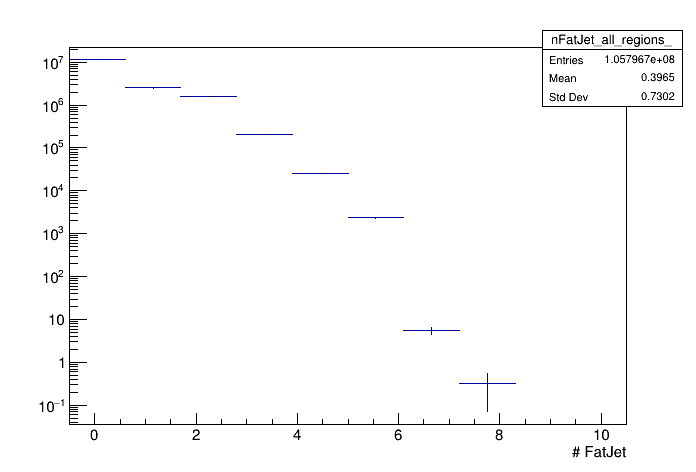

In [24]:
c1 = ROOT.TCanvas()
c1.Draw()
c1.SetLogy()
histos_met[0].Draw()